# Exercise 04 - Pressure Transducer
\- Gugliemo Grillo

<div>
<center>
    <img src="https://i.imgur.com/CxYNAYL.png" width="700"/>
</center>
</div>

### Transfer function

We call $P_{fb}$ the preassure coming from the output V and passing throught the $-\beta$ stage. the relevant equations of the system are:
\begin{array}{rcl}
P_{fb} &=& - \beta V \\
P_e + P_{fb} &=& P\\
V &=& P \frac{G_0}{1+ i f/f_0} \\
\end{array}
Solving for $V/P_e$ we obatain:
$$ h(f) = \frac{V}{P_e} = \frac{G_c}{1+G_c \beta} = \frac{G}{1+i f/f_0 + \beta G}$$
where we choose $G_c = \frac{G}{1+if/f_0}$ in order to preserve the canonical gain equation.

In [7]:
# packages used
import scipy.constants
from scipy import signal
from scipy.integrate import quad

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Given constans
OR = 1 # \pm, [Pa], operating range
G = 100 # V/Pa
F0 = 10 # Hz, roll of frequency
BETA = 1 # Pa/V

# Parameters redefinition
Gc = lambda f: G / (1+ 1j * f/F0)
#h = lamda f: Gc(f)/ (1+beta*Gc(f))

# Show value
print("Gain at roll of frequency {:.5}".format(Gc(F0)) )

Gain at roll of frequency (50-50j)


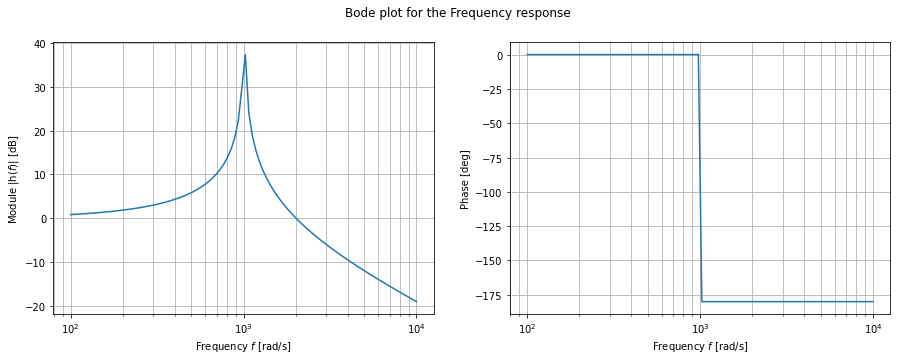

In [10]:
sys = signal.TransferFunction([G], [1j/F0, 1+BETA*G])
w, mag, phase = signal.bode(sys)

# Bode plot
fig, axis = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Bode plot for the Frequency response')

axis[0].plot(w, mag)
axis[0].set_xscale('log')
axis[0].set_xlabel("Frequency $f$ [rad/s]")
axis[0].set_ylabel("Module |h($f$)| [dB]")
axis[0].grid(True, which="both")

axis[1].plot(w, phase)
axis[1].set_xscale('log')
axis[1].set_xlabel("Frequency $f$ [rad/s]")
axis[1].set_ylabel("Phase [deg]")
axis[1].grid(True, which="both")

plt.show()

### Saturation


The frequency response can be obtained by Fourier-transforming both sides of the equation:
$$\mathcal{FT} \bigl[ \ddot{\phi}(t)+ k^2 \dot{\phi}(t) + \omega_0^2 \phi(t)\bigr](\omega) = \mathcal{FT} \bigl[\tau(t) \bigr](\omega)$$

$$\Longrightarrow (i\omega)^2\phi(\omega)+ k^2 i \omega \phi(\omega) + \omega_0^2 \phi(\omega) = \tau(\omega)$$

$$\Longrightarrow \phi(\omega) = \frac{1}{(\omega_0^2 - \omega^2 + ik^2 \omega)} \tau(\omega)$$


The frequency response is then:
$$h(\omega) = \frac{1}{(-\omega^2 + ik^2 \omega + \omega_0^2)}$$

### Impulse response
The impulse response can be found either by the inverse Fourier-transform of the frequency response or by solving the homogeneous equation associated to the differential equation $\ddot{\phi}(t)+ k^2 \dot{\phi}(t) + \omega_0^2 \phi(t) = \tau(t)$. Both methods will be presented in $\textit{Appendix A}$. The impulse response is:
$$h(t) = \frac{2}{\sqrt{\nabla}} e^{- \frac{k^2}{2} t} sin(\frac{\sqrt{\nabla}}{2}t)$$

where $\nabla = 4\omega_0^2 - k^2$

nabla: 39.225


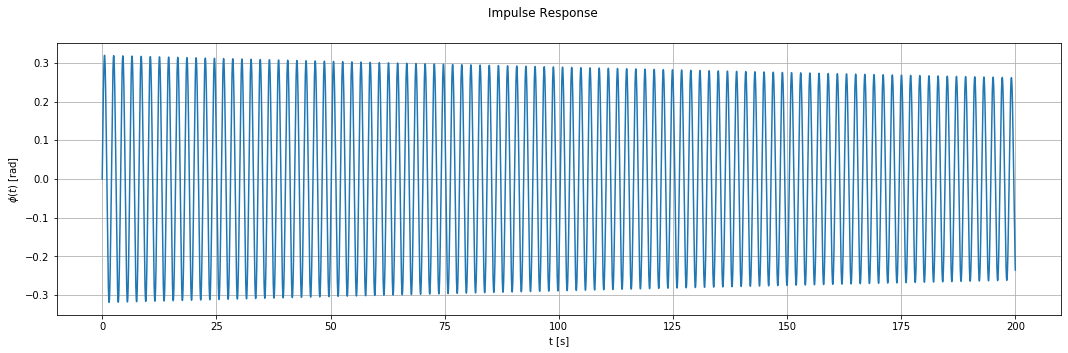

In [7]:
nabla = 4*W02-K2
print("nabla: {:.5}".format(nabla))

# Plot of the free evolution
def impulse_response(t):
    return 2/np.sqrt(nabla) * np.exp(-K2 * t/2) * np.sin( np.sqrt(nabla) / 2 * t)

t_array = np.linspace(0, 200, int(1e6) )
y_array = impulse_response(t_array)

fig, ax = plt.subplots(1,1, figsize=(18, 5))
fig.suptitle('Impulse Response')

ax.plot(t_array, y_array)
ax.set_xlabel("t [s]")
ax.set_ylabel("$\phi(t)$ [rad]")
ax.grid(True, which="both")

### Free evolution
The free evolution is the output measured when there is no input, i.e. the solution to the homogeneous equation:
$$\ddot{\phi}(t)+ k^2 \dot{\phi}(t) + \omega_0^2 \phi(t) = 0$$

which, as shown in $\textit{Appendix A: Impulse response - Homogeneous Equation}$, is:
$$ \phi_0(t) = c_1 e^{-\frac{-k^2 + \sqrt{\nabla}}{2} t} + c_2 e^{-\frac{-k^2 - \sqrt{\nabla}}{2} t} $$

### Response to a gaussian pulse
The response to a Gaussian pulse $A e^{-\frac{(t'-b)^2}{2c}}$ is:
$$o_g(t)=-\sqrt{\frac{8 c}{\nabla}} e^{-\frac{(t-b-\alpha c)^2}{2c}-\frac{t-b}{2 c}} sin(\beta(t-b-\alpha c)) I$$
Where $\alpha = \frac{k^2}{2}$, $\beta=\frac{\sqrt{\nabla}}{2}$ and $I$ is a constant coming from the convolution (see $\textit{Appendix A: Gaussian Pulse Response}$).

Value of the constant: I=0.013158201
Absolute error: 1e-09


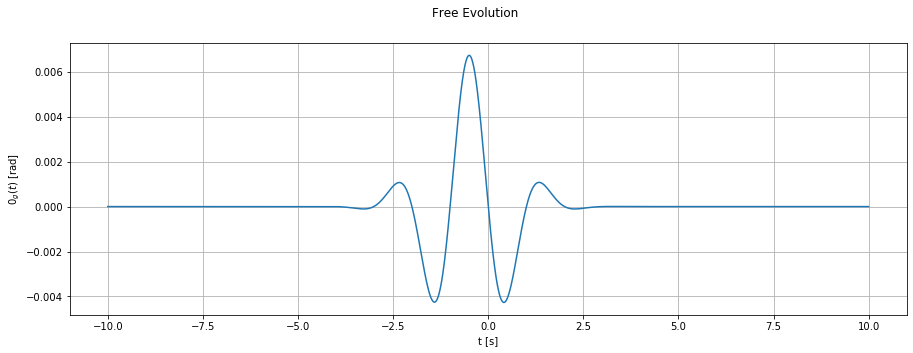

In [8]:
# Normal gaussian with unit variance and zero mean
A = 1/np.sqrt(2*np.pi)
b = 0
c = 1

# New parameters:
alpha = K2 / 2
beta = np.sqrt(nabla) /2

# numerical integral, see Appendix A: Gaussian Pulse Response
def integrand(t):
    return np.exp(- np.power(t, 2) ) * np.cos(beta*np.sqrt(2*c)* t)

I = quad(integrand, -1*np.inf, np.inf)
print('Value of the constant: I={:.9f}\nAbsolute error: {:.1}'.format(I[0], I[1]))

# Plot of the response
def g_response(t):
    return - np.sqrt(8*c/nabla) * np.exp(- np.power(t-b-alpha*c, 2) / (2*c) - (t-b)/(2*c)) * np.sin(beta*(t-b-alpha*c)) * I[0]

    
t_array = np.linspace(-10, 10, int(1e6) )
y_array = g_response(t_array)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
fig.suptitle('Free Evolution')

ax.plot(t_array, y_array)
ax.set_xlabel("t [s]")
ax.set_ylabel("$0_g(t)$ [rad]")
ax.grid(True, which="both")

## Appendix A
> \- You're mad!'
>
> \- Thank goodness for that because if I wasn't, this'd probably never work.

In this appendix I'm going to show all the mathematical calculation skipped in the main body. This calculation were made by hand because, somehow, neither Mathematica nor Wolframalpha, managed to find the the correct solution (e. g. Wolframalpha gave a complex function as a result when evaluating the inverse Fourier transform of the frequency response. A clear mistake as the impulsed response is supposed to be real).

### Impulse response - Inverse Fourier Transform
We now want to evaluate the inverse Fourier transform of the frequency response:
$$\mathcal{FT}^{-1}\bigl[h(\omega)\bigr] = \mathcal{FT}^{-1}\bigl[\frac{1}{(-\omega^2 + ik^2 \omega + \omega_0^2)}\bigr]$$

In order to simplify the the math required we can rewrite the fraction as 
$$\frac{1}{(-\omega^2 + ik^2 \omega + \omega_0^2)} = \frac{1}{2a}\bigl[ \frac{1}{a+(\omega - \frac{ik^2}{2})} + \frac{1}{a-(\omega - \frac{ik^2}{2})}\bigr]$$

where $a^2=\omega_0^2-\frac{k^4}{4}$.We can now do two single inverse Fourier transform and add them:
$$\mathcal{FT}^{-1}\bigl[ \frac{1}{2a} \frac{1}{a+(\omega - \frac{ik^2}{2})} \bigr] =  \frac{1}{2a}\frac{1}{2\pi} \int_{-\infty}^{+\infty}\frac{1}{a+(\omega - \frac{ik^2}{2})} e^{i\omega t} d\omega$$

We can now perform the change of variable $\omega ' = \omega - \frac{ik^2}{2} + a$ and obtain:
$$ \frac{1}{2a}\frac{1}{2\pi} \int_{-\infty}^{+\infty}\frac{1}{\omega '} e^{i\omega ' t} e^{-iat - \frac{k^2}{2}t} d\omega ' = \frac{i}{4a \pi}e^{-iat - \frac{k^2}{2}t} \int_{-\infty}^{+\infty}\frac{1}{i\omega '} e^{i\omega ' t}  d\omega '$$
We can now use the known formula
$$ \mathcal{FT}\bigl[ e^{\eta t}\theta(t)\bigr] = \frac{1}{\eta + i\omega}$$

and assume $\eta = 0$ to write
$$\frac{i}{4a \pi}e^{-iat - \frac{k^2}{2}t} \int_{-\infty}^{+\infty}\frac{1}{i\omega '} e^{i\omega ' t}  d\omega ' = \frac{i}{2a}e^{-iat - \frac{k^2}{2}t} \theta(t)$$

In similar fashion, we have
$$ \mathcal{FT}^{-1}\bigl[ \frac{1}{2a} \frac{1}{a-(\omega - \frac{ik^2}{2})} \bigr] = -\frac{i}{2a}e^{+iat - \frac{k^2}{2}t} \theta(t) $$

The sum of the two parts give us the desired inverse transform:
$$\mathcal{FT}^{-1}\bigl[\frac{1}{(-\omega^2 + ik^2 \omega + \omega_0^2)}\bigr] = \frac{i}{2a}e^{-iat - \frac{k^2}{2}t} \theta(t) - \frac{i}{2a}e^{+iat - \frac{k^2}{2}t} \theta(t) = \frac{i}{2a}\theta(t)e^{- \frac{k^2}{2}t} \bigl( e^{-iat}  - e^{+iat} \bigr) = \frac{1}{a}\theta(t)e^{- \frac{k^2}{2}t}sin(at)$$

The impulse response is therefore:
$$h(t)= \frac{1}{a}\theta(t)e^{- \frac{k^2}{2}t}sin(at)$$

### Impulse response - Homogeneous Equation
The system is governed by a non-homogeneous differential equation:
$$\ddot{\phi}(t)+ k^2 \dot{\phi}(t) + \omega_0^2 \phi(t) = \tau(t)$$

In order to find the input-output relation we have to solve this differential equation. This can be done by solving the associated ODE and adding a particular solution. The particular solution can be found with the use of the convolution method. Let's start with the homogeneous equation (which will give us, as a subproduct, the free evolution of the system)
$$\ddot{\phi}_0(t)+ k^2 \dot{\phi}_0(t) + \omega_0^2 \phi_0(t) = 0$$

The $\Delta$ of the associated characteristic polynomial is $\Delta = (k^2)^2 -4 \omega_0^2$. With the given value of the constants we have $\Delta = 0.002^2 -4*9.8066 < 0$. For convenience we set $\nabla = - \Delta$. The solution of the characteristic polynomial are then: $\phi_{1,2} = \frac{-k^2 \pm \sqrt{\nabla}}{2}$ and the solution of the homogeneous differential equation is therefore:
$$ \phi_0(t) = c_1 e^{-\frac{-k^2 + \sqrt{\nabla}}{2} t} + c_2 e^{-\frac{-k^2 - \sqrt{\nabla}}{2} t} $$

The particular solution can be found as the convolution between the output and the homogeneous solution with initial condition $\phi(t=0)=0$ and $\dot{\phi}(t=0)=1$. The first initial condition gives us the relation $c_1 = -c_2$ while the latter $c_1 = \frac{1}{i \sqrt{\nabla}}$. The solution desired is then:
$$ \phi_{ic}(t) = \frac{2}{\sqrt{\nabla}} e^{- \frac{k^2}{2}t}sin(\frac{\sqrt{\nabla}}{2}t)$$

We can then write the general solution as:
$$ \phi(t) = c_1 e^{-\frac{-k^2 + \sqrt{\nabla}}{2} t} + c_2 e^{-\frac{-k^2 - \sqrt{\nabla}}{2} t} +
\int_{-\infty}^{+\infty} \frac{2}{\sqrt{\nabla}} e^{- \frac{k^2}{2}t'}sin(\frac{\sqrt{\nabla}}{2}t') \tau(t-t') \theta(t') dt'$$

Where the $\theta(t')$ was introduced to force the principle of causality (when $t'<0$ we are considering the forces in the future). This expression is useful because the first term is the free evolution, while the second is the response to and input $\tau$. If we choose the input to be a Dirac's delta we get the impulse response
$$ h(t) = \frac{2}{\sqrt{\nabla}} e^{- \frac{k^2}{2}t}sin(\frac{\sqrt{\nabla}}{2}t)\theta(t)$$

This expression can be rewritten to coincide with the one obtained before if we notice that $\nabla = 4 a^2$.

### Gaussian Pulse Response
Let's take a general Gaussian $A e^{-\frac{(t-t'-b)^2}{2c}}$, the pulse response is:
$$\int_{-\infty}^{+\infty}h(t') A e^{-\frac{(t-t'-b)^2}{2c}} dt' = \int_{-\infty}^{+\infty}\frac{2}{\sqrt{\nabla}} e^{- k^2 t'/2} sin(\frac{\sqrt{\nabla}}{2}t') A e^{-\frac{(t-t'-b)^2}{2c}} dt' = \frac{2}{\sqrt{\nabla}} \int_{-\infty}^{+\infty} e^{- \alpha t'} sin(\beta t') A e^{-\frac{(t'-\mu)^2}{2c}} dt'$$
Were we chosen $\alpha = \frac{k^2}{2}$, $\beta=\frac{\sqrt{\nabla}}{2}$ and $\mu(t) = \mu=t-b$. Performing a square completion we obtain:

$$\frac{2}{\sqrt{\nabla}} e^{-\frac{(\mu-\alpha c)^2}{2c}-\frac{\mu}{2c}} \int_{-\infty}^{+\infty} e^{-\frac{(t'-(\mu-\alpha c))^2}{2c}} sin(\beta t') dt'$$

We then perform a change of variable $t'' = \frac{t'-(\mu-\alpha c)}{\sqrt{2c}}$ and rewrite:

$$\frac{2 \sqrt{2c}}{\sqrt{\nabla}} e^{-\frac{(\mu-\alpha c)^2}{2c}-\frac{\mu}{2c}} \int_{-\infty}^{+\infty} e^{-t''^2} sin(\beta \sqrt(2c) t''-\beta(\mu-\alpha c)) dt'$$
Finally we can use Trigonometric Addition Formula $sin(a-b) = sin(a)cos(b)+cos(a)sin(b)$ to write:

$$\frac{2 \sqrt{2c}}{\sqrt{\nabla}} e^{-\frac{(\mu-\alpha c)^2}{2c}-\frac{\mu}{2c}} \int_{-\infty}^{+\infty} e^{-t''^2} \bigl[ sin(\beta \sqrt{2c} t'')cos(\beta(\mu-\alpha c)) - cos(\beta \sqrt{2c} t'')sin(\beta(\mu-\alpha c)) \bigr] dt'' $$
We are now presented with two integral. Luckily one of them is zero because the integrand is odd, while the other does not depend on $t$ but only on $t''$.
$$ \int_{-\infty}^{+\infty} e^{-x^2}sin(ax) = 0$$

We are left with 
$$-\frac{2 \sqrt{2c}}{\sqrt{\nabla}} e^{-\frac{(\mu-\alpha c)^2}{2c}-\frac{\mu}{2c}} sin(\beta(\mu-\alpha c))\int_{-\infty}^{+\infty} e^{-t''^2}cos(\beta \sqrt{2c} t'') dt'' $$
The integral can be solved numerically. We just take it's value to be $\textit{I}$. The explicit dependence on time is:
$$-\sqrt{\frac{8c}{\nabla}} e^{-\frac{(t-b-\alpha c)^2}{2c}-\frac{t-b}{2c}} sin(\beta(t-b-\alpha c)) I$$